# Logistic Regression Model

In this notebook we model the probability of a galaxy of being quenched using a logistic regression model. First, we explore the dependence of quenching with three galaxy properties stellar mass, distance from the cluster center and line of sight velocity. Second, we explore correlations with the halo properties. In the Bayesian Hierarchical framework we will estimate for each halo the slope between quenching and a galaxy property with the constraint of the overall dataset.

In [1]:
%matplotlib inline

import pickle
# from collections import OrderedDict

import pandas as pd
import numpy as np
from scipy import stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
# from mlxtend.plotting import plot_confusion_matrix

# import theano
import pymc3 as pm

# from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from IPython.display import HTML

In [2]:
cd ..

/Users/jesteves/Documents/GitHub/galaxyFormation


## Load the Data

In [3]:
import sys
sys.path.append('./scripts')
from file_loc import FileLocs
from utils import check_non_valid_number, gaussian_kde
import seaborn as sns
sns.set_context('poster', font_scale=0.7)

In [4]:
fl = FileLocs(dataset='sdss')
gal0 = fl.load_catalogs('galaxy/main')

mask  = (gal0['VLOS_MASK']).astype(bool)
mask &= gal0['VOLUME_LIM_MASK'].astype(bool)
mask &= gal0['p_infall']>0.5

gal = gal0[mask].copy()
cat = fl.load_catalogs('cluster/frac_vl')

Loading Catalog: ./data/catalogs/SDSS/groups_deCarvalho2017_R200m_galaxies_final_flag_johnnyheq_pp.csv
Loading Catalog: ./data/catalogs/SDSS/groupCatalog_Yang_deCarvalho2017_frac_vl.csv


In [5]:
gid = np.array(gal['Yang'])

zgal = np.array(gal['z'])
Mr   = np.array(gal['Mr'])

log_smass = np.array(gal['mass'])
smass = 10**log_smass
redshift = np.array(gal['redshift'])

rn = np.array(gal['Rm'])
vn = np.array(gal['vlosn'])
morph_type = np.array(gal['TType'])
ssfr = np.array(gal['ssfr'])

# sfr classification
sf   = np.array(gal['SF']).astype(int)
qf   = (1-sf).astype(int)

# morphological classification
sp   = np.where(gal['TType'] > 0, 1, 0).astype(int)
ell  = np.where(gal['TType'] <=0, 1, 0).astype(int)
s0   = check_non_valid_number(gal['Pbulge'])
s0[np.isnan(s0)] = 0.

# b/t definition
bt = np.array(gal['BT'])
bt2 = np.where(bt>=0.5,1.,bt)
bt2 = np.where(bt<0.5,0.,bt2)

# dynamical probabilities
Pi   = np.array(gal['p_infall'])
Po   = np.array(gal['p_orbital'])
Pn   = np.array(gal['p_interlopers'])
Pf = np.where(rn>2,Pn,0.)

m200 = np.array(gal['M200c'])

# mask
bt_mask = bt>=0.

## Quenching Model

The likelihood is:
$$
P(Quenched, Galaxy | R, M_{\star}, \sigma,) = Logit(R,M_{\star}, \sigma) \times Bernoulli(p_{infall})
$$

With the Logit model and the linear relation
$$
y = b_0 + b_1 (R/R_{200m}) + b_{2} (M_{\star}/M_0) + b_3 \sigma
$$

In [6]:
county_idxs, counties = pd.factorize(gid)
coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idxs)),
}

In [11]:
with pm.Model(coords=coords) as manual_logistic_model:
    # Independent parameters for each county
    # cluster ID
    cidx = pm.Data("county_idx", county_idxs, dims="obs_id")
    
    # x variables
    Rn = pm.Data("Rn", rn, dims="obs_id")
    Vn = pm.Data("Vn", vn, dims="obs_id")
    Ms = pm.Data("Ms", np.log10(smass/1e10), dims="obs_id")
    
    # Hyperpriors:
    b0 = pm.Normal("b0", mu=0.0, sigma=20.0)
    b1 = pm.Normal("b1", mu=0.0, sigma=20.0)
    b2 = pm.Normal("b2", mu=0.0, sigma=20.0)
    b3 = pm.Normal("b3", mu=0.0, sigma=20.0)
    
    s0 = pm.Exponential("s0", 1.0)
    s1 = pm.Exponential("s1", 1.0)
    s2 = pm.Exponential("s2", 1.0)
    s3 = pm.Exponential("s3", 1.0)
    
    # slopes & intercept for each cluster
    intercept = b0 #pm.Normal('intercept', mu=b0, sigma=s0, dims="county")
    beta_1 = pm.Normal('b_1_cls', mu=b1, sigma=s1, dims="county")
    beta_2 = pm.Normal('b_2_cls', mu=b2, sigma=s2, dims="county")
    beta_3 = pm.Normal('b_3_cls', mu=b3, sigma=s3, dims="county")
    
    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept + beta_1[cidx] * Rn 
                             + beta_2[cidx] * Ms + beta_3[cidx] * Vn)
        
    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=qf, dims="obs_id")
    
# pm.model_to_graphviz(manual_logistic_model)

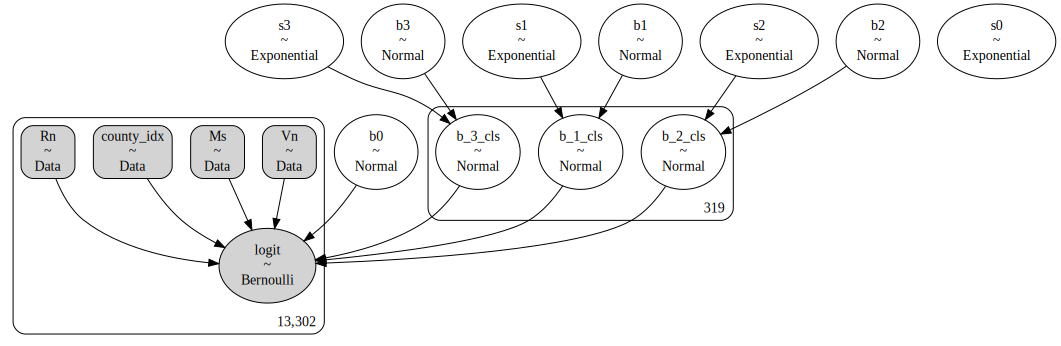

In [14]:
pm.model_to_graphviz(manual_logistic_model)

In [42]:
# # Inference button (TM)!
# with manual_logistic_model:
#     hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9, cores=6)

In [ ]:
az.plot_forest(
    varying_intercept_trace, var_names=["beta", "a_county"], r_hat=True, combined=True, textsize=9
);


In [ ]:
pm.plot_trace(trace);


In [ ]:
trace.varnames

In [ ]:
plt.hist(trace['beta_3'])